In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [6]:
batch_size = 100

In [7]:
original_dim = 784

In [8]:
latent_dim = 2

In [9]:
intermediate_dim = 256

In [10]:
epochs = 20

In [11]:
epsilon_std = 1.0

In [13]:
x = Input(batch_shape = (batch_size,original_dim))

In [14]:
h = Dense(intermediate_dim,activation='relu')(x)

In [15]:
z_mean = Dense(latent_dim)(h)

In [16]:
z_log_var = Dense(latent_dim)(h)

In [18]:
def Sampling(args):
    z_mean,z_log_var = args
    epsilon = K.random_normal(shape = (batch_size,latent_dim),mean = 0.0,stddev = 1)
    return z_mean + K.exp(z_log_var/2)*epsilon

In [20]:
z = Lambda(Sampling,output_shape = (latent_dim,))([z_mean,z_log_var])

In [21]:
decoder_h = Dense(intermediate_dim,activation = 'relu') 

In [23]:
decoder_mean = Dense(original_dim,activation = 'sigmoid')

In [24]:
h_decoded = decoder_h(z)

In [25]:
x_decoded_mean = decoder_mean(h_decoded)

In [27]:
def vae_loss(x,x_decoded_mean):
    xent_loss = original_dim*metrics.binary_crossentropy(x,x_decoded_mean)
    kl_loss = -0.5*K.sum(1+z_log_var-K.square(z_mean)-K.exp(z_log_var),axis=-1)
    return xent_loss + kl_loss

In [28]:
vae = Model(x,x_decoded_mean)
vae.compile(optimizer = 'rmsprop',loss = vae_loss)

In [29]:
(x_train,y_train),(x_test,y_test) = mnist.load_data()

In [30]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [31]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 29s - loss: 190.8423 - val_loss: 174.4103
Epoch 2/20
60000/60000 [==============================] - 29s - loss: 170.9547 - val_loss: 169.2521
Epoch 3/20
60000/60000 [==============================] - 31s - loss: 167.6527 - val_loss: 166.1002
Epoch 4/20
60000/60000 [==============================] - 32s - loss: 165.7907 - val_loss: 165.3490
Epoch 5/20
60000/60000 [==============================] - 33s - loss: 164.5835 - val_loss: 165.3117
Epoch 6/20
60000/60000 [==============================] - 33s - loss: 163.7556 - val_loss: 162.6059
Epoch 7/20
60000/60000 [==============================] - 33s - loss: 163.2209 - val_loss: 164.7893
Epoch 8/20
60000/60000 [==============================] - 31s - loss: 163.1196 - val_loss: 164.0569
Epoch 9/20
60000/60000 [==============================] - 31s - loss: 163.4374 - val_loss: 161.0320
Epoch 10/20
60000/60000 [=========================

In [32]:
encoder = Model(x, z_mean)

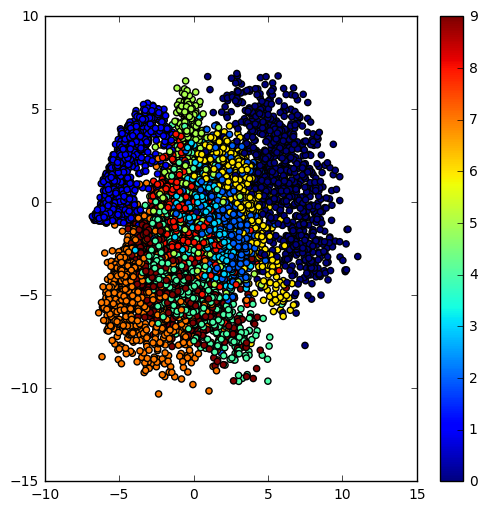

In [33]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [34]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [35]:
n = 15

In [37]:
digit_size = 28

In [38]:
figure = np.zeros((digit_size * n, digit_size * n))

In [39]:
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))


In [40]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

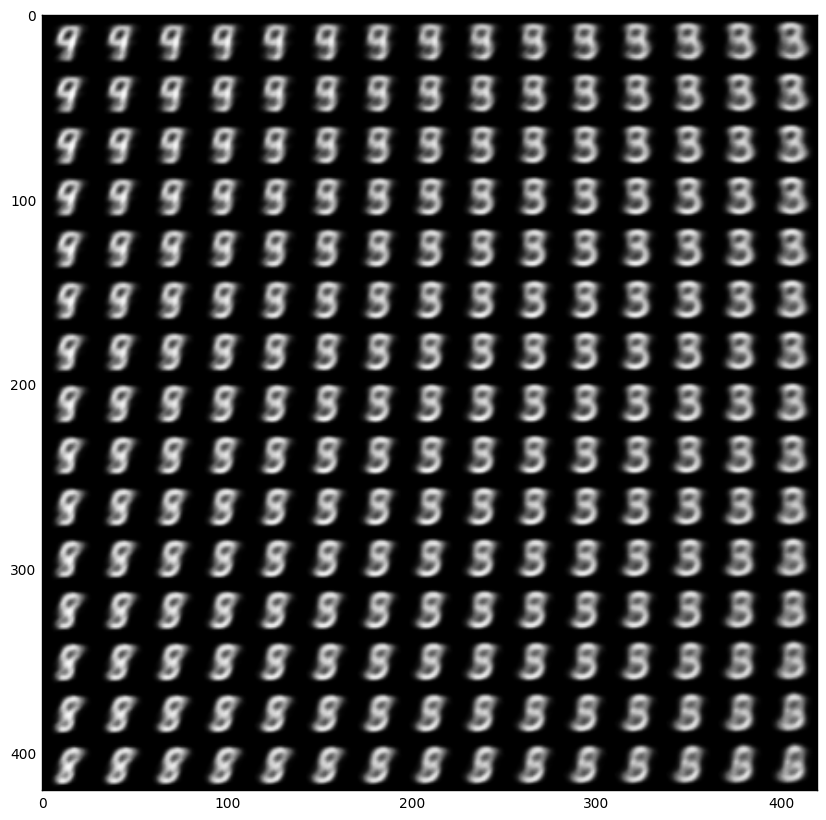

In [41]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()